# Pylops - multi-process linear operators

### Author: M.Ravasi

In this notebook we will experiment with multiprocess/multithread to speed up embarassingly parallel operators like VStack, HStack, BlockDiag

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import time

import pylops
import multiprocessing as mp

from scipy.sparse import csr_matrix, vstack, rand
from scipy.linalg import lstsq, solve, pinv
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from scipy.sparse.linalg import cg, lsqr

from pylops.utils import dottest
from pylops.basicoperators import *
from pylops.waveeqprocessing.wavedecomposition import *

In [2]:
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [3]:
def scalability_test(Op, x, workerexp=2):
    workers=list()
    compute_times=list()
    speedup=list()
    for i in range(workerexp):
        workers.append(2 ** i)
        print('Working with %d workers...' % workers[-1])
        # update number of workers
        Op.nproc = workers[i]
        print(Op.pool)
        # run forward
        ptime = time.time()
        result = Op * x
        ptime = time.time() - ptime
        compute_times.append(ptime)
        speedup.append(compute_times[0]/ptime)
    Op.pool.close()
    return workers, compute_times, speedup

## Simple example

In [4]:
def fun(G, x, i):
    print('Starting:', mp.current_process().name) 
    #time.sleep(1)
    return np.dot(G, x)

## HStack with matrix mult

Overhead seems to kill benefit

In [5]:
nprocs = 4 #mp.cpu_count()
print("%d worker available" %nprocs)

n = 5000
N = nprocs * 4
G = np.random.normal(0., 1., (n,n))
x = np.ones(n*N)

Gop = MatrixMult(G)
Sop = HStack([G]*N)
S1op = HStack([G]*N, nproc=nprocs)

4 worker available


In [6]:
y = Sop * x 
y1 = S1op * x

dottest(Sop, verb=True)
dottest(S1op, verb=True)
print(np.allclose(y, y1))

Dot test passed, v^H(Opu)=-15643.044534920511 - u^H(Op^Hv)=-15643.044534920478
Dot test passed, v^H(Opu)=-14620.030158817615 - u^H(Op^Hv)=-14620.030158817746
True


In [7]:
t0 = time.time()
Sop * x
print(time.time()-t0)

0.04645204544067383


In [8]:
t0 = time.time()
S1op * x
print(time.time()-t0)

4.794013977050781


## BlockDiag with matrix mult

Overhead seems to kill benefit

In [9]:
Sop = BlockDiag([G]*N, nproc=1)
print(Sop.pool)
Sop.nproc = 2
print(Sop.pool)
Sop.nproc = 4
print(Sop.pool)

None
<multiprocessing.pool.Pool state=RUN pool_size=2>
<multiprocessing.pool.Pool state=RUN pool_size=4>


In [10]:
workers, compute_times, speedup = scalability_test(Sop, np.ones(N*n), workerexp=4)

Working with 1 workers...
<multiprocessing.pool.Pool state=CLOSE pool_size=4>
Working with 2 workers...
<multiprocessing.pool.Pool state=RUN pool_size=2>
Working with 4 workers...
<multiprocessing.pool.Pool state=RUN pool_size=4>
Working with 8 workers...
<multiprocessing.pool.Pool state=RUN pool_size=8>


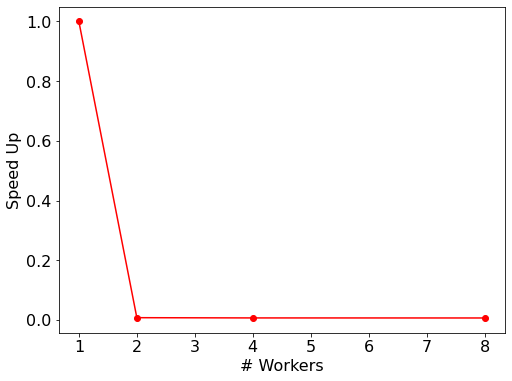

In [11]:
plt.plot(workers,speedup,'ro-')
plt.xlabel('# Workers');
plt.ylabel('Speed Up');

## PressureToVelocity
Repeat ns times the same operation with ffts

In [12]:
nprocs = 4 #mp.cpu_count()-2
print("%d worker available" %nprocs)

nt, nr, ns = 1024, 512, 200
nfftk, nfftf = 512, 1024
PtoVop = PressureToVelocity(nt, nr, 1., 1.,
                            1000, 2000,
                            nffts=(nfftk, nfftf),
                            critical=100., ntaper=11,
                            topressure=False, dtype='complex128')           
PtoVop1 = BlockDiag([PtoVop]*ns)
PtoVop2 = BlockDiag([PtoVop]*ns, nproc=nprocs)

PtoVop1, PtoVop2

4 worker available


/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/waveeqprocessing/wavedecomposition.py:135: RuntimeWarning: divide by zero encountered in true_divide
  OBL = Kz / (rho * np.abs(F))
/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/waveeqprocessing/wavedecomposition.py:135: RuntimeWarning: invalid value encountered in true_divide
  OBL = Kz / (rho * np.abs(F))


(<104857600x104857600 BlockDiag with dtype=complex128>,
 <104857600x104857600 BlockDiag with dtype=complex128>)

In [13]:
y = PtoVop1 * np.ones(104857600)
y1 = PtoVop2 * np.ones(104857600)
np.allclose(y, y1)

True

In [14]:
%timeit -n1 -r2 PtoVop1 * np.ones(104857600)

5.62 s ± 93.9 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)


In [15]:
%timeit -n1 -r2 PtoVop2 * np.ones(104857600)

5.96 s ± 70.3 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)


In [16]:
workers, compute_times, speedup = scalability_test(PtoVop1, np.ones(104857600), workerexp=4)

Working with 1 workers...
None
Working with 2 workers...
<multiprocessing.pool.Pool state=RUN pool_size=2>
Working with 4 workers...
<multiprocessing.pool.Pool state=RUN pool_size=4>
Working with 8 workers...
<multiprocessing.pool.Pool state=RUN pool_size=8>


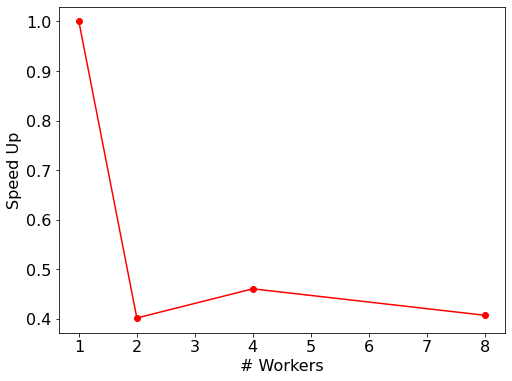

In [17]:
plt.plot(workers, speedup,'ro-')
plt.xlabel('# Workers');
plt.ylabel('Speed Up');

Working with 1 workers...
Working with 2 workers...
Working with 4 workers...
Working with 8 workers...
Working with 1 workers...
Working with 2 workers...
Working with 4 workers...
Working with 8 workers...


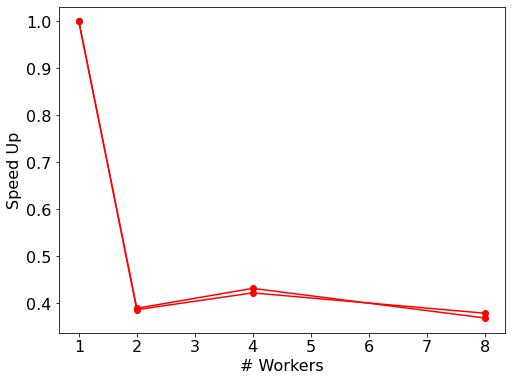

In [18]:
from pylops.utils.multiproc import scalability_test as stest

workers = [1, 2, 4, 8]
compute_times, speedup = stest(PtoVop1, np.ones(PtoVop1.shape[1]), workers=workers, forward=True)
plt.plot(workers, speedup,'ro-')
plt.xlabel('# Workers')
plt.ylabel('Speed Up')

compute_times, speedup = stest(PtoVop1, np.ones(PtoVop1.shape[0]), workers=workers, forward=False)
plt.plot(workers, speedup,'ro-')
plt.xlabel('# Workers');
plt.ylabel('Speed Up');